In [1]:
import pandas as pd 
import numpy as np 


In [2]:
%%capture
!pip install transformers --upgrade
!pip install mosestokenizer
!pip install sentencepiece
!pip install ast

In [3]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from google.colab import drive
import re
from bs4 import BeautifulSoup

In [4]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
'''
Construct object in BERT sentiment classifier class
'''
sentiment_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden states.
)

sentiment_model.cuda() # Puts model on GPU

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [6]:
'''
Load pretrained sentiment model parameters
'''
sentiment_model.load_state_dict(torch.load("/content/drive/My Drive/English_sentiment_model.pt", map_location=torch.device('cpu')), strict=False)

_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids'], unexpected_keys=[])

In [7]:
sentiment_model.eval() # Put model in inference (as opposed to training) mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
'''
Load tokenizer for sentiment model
'''
sentiment_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [9]:
# gets the text into the format we want
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, "lxml").get_text() # turns xml-formatted text into regular text
  tweet = re.sub(r"@[A-Za-z0-9]+", " ", tweet) # gets rid of all user references in tweets (i.e. "@username")
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) # gets rid of URLs
  tweet = re.sub(r"[^A-Za-z.!?áéíóúüñ¿ÁÉÍÓÚÜÑ']", " ", tweet) # gets rid of any non-standard characters in the tweets
  tweet = re.sub(r" +", " ", tweet) # replaces all excess whitespace with a single space

  return tweet # gives us our cleaned tweet

In [10]:
def predict_sentiment(tweet):

    '''
    Predict the sentiment of an input text
    '''
    
    tweet = clean_tweet(tweet)
    tweet_input_id = []
    tweet_attention_mask = []

    tweet_dict = sentiment_tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            truncation=True,           # Explicitly enable truncation
                            padding = 'max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    tweet_input_id.append(tweet_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    tweet_attention_mask.append(tweet_dict['attention_mask'])

    # Convert the lists into tensors.
    tweet_input_id = torch.cat(tweet_input_id, dim=0)
    tweet_attention_mask = torch.cat(tweet_attention_mask, dim=0)

    tweet_data = TensorDataset(tweet_input_id, tweet_attention_mask)
    
    tweet_dataloader = DataLoader(tweet_data)
    
    for data in tweet_dataloader:
        tweet_input_id = data[0].to(device=torch.device('cuda'))
        tweet_attention_mask = data[1].to(device=torch.device('cuda'))
    
    tweet_logits = sentiment_model(tweet_input_id, token_type_ids=None, attention_mask=tweet_attention_mask)
    
    tweet_logits = tweet_logits[0].detach().cpu().numpy()

    tweet_logits = torch.Tensor(tweet_logits)

    softmax = torch.nn.Softmax(dim=1)
    prob_dist = softmax(tweet_logits)

    sentiment_pred = prob_dist.tolist()

    sentiment_pred = sentiment_pred[0][1]

    return sentiment_pred

In [11]:
generations = pd.read_csv('https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/FullV2/generations_table_full.csv')
information = pd.read_csv('https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/FullV2/information_table_full.csv')

In [12]:
generations 

,vignette_name,generation_number,generation_time,response,reflection_score,id
0,ring,0,12767,make fake rings,55,5ae208fe38df950001454cc3
1,ring,1,8718,call the taxi driver,75,5ae208fe38df950001454cc3
2,ring,2,4017,cry,2,5ae208fe38df950001454cc3
3,ring,3,12310,interrupt the bride and groom,61,5ae208fe38df950001454cc3
4,ring,4,8686,run away,1,5ae208fe38df950001454cc3
...,...,...,...,...,...,...
10028,gas,0,3928,tell her no,32,5dfa56fddc265f7ac3bee209
10029,gas,2,7148,take her the whole way,100,5dfa56fddc265f7ac3bee209
10030,gas,3,21327,"take her to my city, then wait while she gets ...",85,5dfa56fddc265f7ac3bee209
10031,gas,4,10469,tell her to call a cab/uber,22,5dfa56fddc265f7ac3bee209


In [13]:

#get individual differences or affective scores
#for global avg. sentiment per person 
averages = {}
pavgs = {}
ascores = {}
for id, group in information.groupby('id'):
  if id not in ascores:
    ascores[id] = {}
  ascores.get(id)['bdi'] = group.iloc[0]['bdi']
  ascores.get(id)['bai'] = group.iloc[0]['bai']
  ascores.get(id)['panas_pos'] = group.iloc[0]['panas_pos']
  ascores.get(id)['openness'] = group.iloc[0]['openness']
  ascores.get(id)['beck'] = ascores.get(id).get('bai') + ascores.get(id).get('bdi')

print(ascores)

gscores = {}
for id, participant in generations.groupby('id'):
  if id not in gscores:
      gscores[id] = {}
      averages[id] = []
  for pos_num, group in participant.groupby('generation_number'):
    if pos_num not in pavgs:
      pavgs[pos_num] = []
    if pos_num not in gscores.get(id):
      gscores.get(id)[pos_num] = []
    for generation in group['response']:
      if not pd.isna(generation):
        s = predict_sentiment(generation)
        gscores.get(id).get(pos_num).append(s)
        pavgs.get(pos_num).append(s)
        averages.get(id).append(s)
    gscores.get(id)[pos_num] = sum(gscores.get(id).get(pos_num))/len(group['response'])
    
  averages[id] = sum(averages.get(id))/len(averages.get(id))
print(gscores)

{'5563984afdf99b672b5749b6': {'bdi': 3, 'bai': 7, 'panas_pos': 32, 'openness': 35, 'beck': 10}, '5591827dfdf99b4fccbdfb21': {'bdi': 27, 'bai': 16, 'panas_pos': 26, 'openness': 27, 'beck': 43}, '55c43918fdf99b080551e044': {'bdi': 13, 'bai': 26, 'panas_pos': 28, 'openness': 33, 'beck': 39}, '55d5e2c9db6a810006fa078b': {'bdi': 18, 'bai': 13, 'panas_pos': 18, 'openness': 29, 'beck': 31}, '55f0c4ba4779250012dd2ff5': {'bdi': 27, 'bai': 21, 'panas_pos': 20, 'openness': 23, 'beck': 48}, '566a1d697da0350005b39de3': {'bdi': 0, 'bai': 0, 'panas_pos': 38, 'openness': 31, 'beck': 0}, '56797198c3041a0012b64b5e': {'bdi': 0, 'bai': 0, 'panas_pos': 34, 'openness': 34, 'beck': 0}, '56f29effed0cf60006911528': {'bdi': 5, 'bai': 7, 'panas_pos': 24, 'openness': 38, 'beck': 12}, '570521cfde5095001018a0c8': {'bdi': 3, 'bai': 14, 'panas_pos': 23, 'openness': 34, 'beck': 17}, '573a8aca67421f000f191c52': {'bdi': 0, 'bai': 4, 'panas_pos': 29, 'openness': 32, 'beck': 4}, '57509d9b363e77000695620b': {'bdi': 2, 'bai

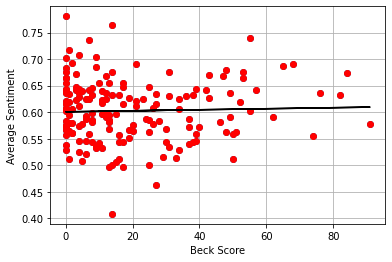

r-value:0.033073
p-value:0.668543


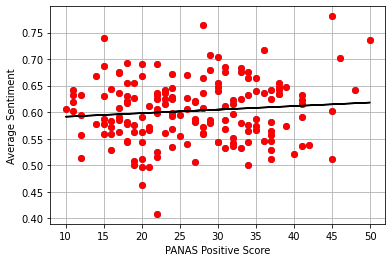

r-value:0.101610
p-value:0.187344


In [14]:
#relationship between beck and avg. sentiment
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats

#plot avg. sentiment against beck
beck = []
sentiment = []
for ind in averages: 
  if ind in ascores: 
    beck.append(ascores.get(ind).get('beck'))
    sentiment.append(averages.get(ind))

#x, y
x = np.array(beck)
y = np.array(sentiment)
plt.scatter(x, y)
plt.xlabel("Beck Score")
plt.ylabel("Average Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#plot avg. sentiment vs panas 
panas = []
sentiment = []
for ind in averages: 
  if ind in ascores: 
    panas.append(ascores.get(ind).get('panas_pos'))
    sentiment.append(averages.get(ind))

#x, y
x = np.array(panas)
y = np.array(sentiment)
plt.scatter(x, y)
plt.xlabel("PANAS Positive Score")
plt.ylabel("Average Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

{0: 0.6213489482422374, 1: 0.6253972536744311, 2: 0.6050737747142579, 3: 0.5980591093177681, 4: 0.582600082268081, 5: 0.5827988388506983}


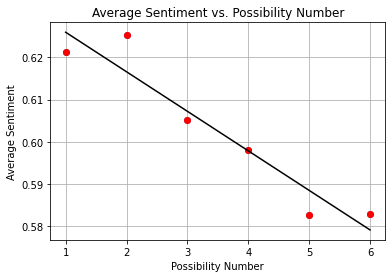

r-value:-0.954077
p-value:0.003115


In [47]:
# just find global avg. sentiment per possibility number here 
pavgs = {}
for id in gscores: 
  for pnum in gscores.get(id):
    if pnum not in pavgs:
      pavgs[pnum] = []
    pavgs.get(pnum).append(gscores.get(id).get(pnum))
for pnum in pavgs:
  pavgs[pnum] = sum(pavgs.get(pnum))/len(pavgs.get(pnum))
print(pavgs)
x = []
y = []
for pnum in pavgs:
  x.append(pnum)
  y.append(pavgs.get(pnum))

x = np.array(x)+1
y = np.array(y)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Average Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Average Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

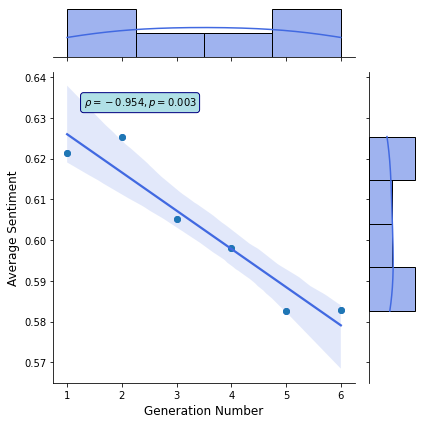

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

# a = np.random.rand(10)
# b = a * 2 + a ** 5

# print("The Rho is {}".format(np.corrcoef(a, b)[0][1]))

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [17]:
#Difference in sentiment value between first and last possibilities
beck = []
diff = []
for id in gscores:
  if id in ascores:
    beck.append(ascores.get(id).get('beck'))
    diff.append(abs(gscores.get(id).get(5) - gscores.get(id).get(0)))


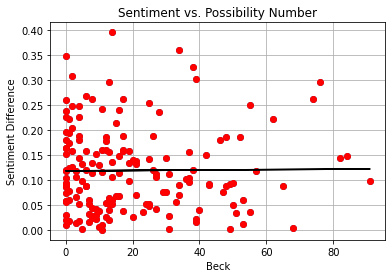

r-value:0.010022
p-value:0.896796


In [18]:
x = np.array(beck)
y = np.array(diff)

plt.scatter(x, y)
plt.xlabel("Beck")
plt.ylabel("Sentiment Difference")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

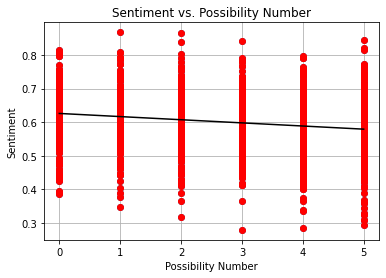

r-value:-0.161593
p-value:0.000000


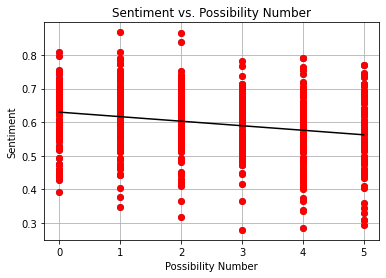

r-value:-0.228544
p-value:0.000000


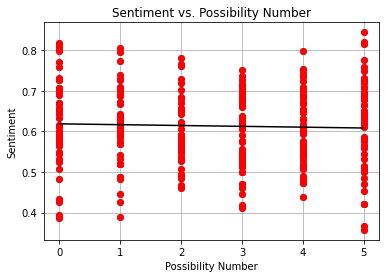

r-value:-0.036873
p-value:0.524638


In [19]:


hthresh = 10
lthresh = 5

# Test: Average sentiment score per possibility

pnum = []
sent = []

for ind in gscores:
  for p in gscores.get(ind):
    s = gscores.get(ind).get(p)
    pnum.append(p)
    sent.append(s)

x = np.array(pnum)
y = np.array(sent)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#for high beck 
pnum = []
sent = []

for ind in gscores:
  for p in gscores.get(ind):
    s = gscores.get(ind).get(p)
    if ind in ascores and ascores.get(ind).get('beck') >= hthresh:
        pnum.append(p)
        sent.append(s)
x = np.array(pnum)
y = np.array(sent)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#for low beck 
pnum = []
sent = []

for ind in gscores:
  for p in gscores.get(ind):
    s = gscores.get(ind).get(p)
    if ind in ascores and ascores.get(ind).get('beck') <= lthresh:
      pnum.append(p)
      sent.append(s)
x = np.array(pnum)
y = np.array(sent)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)



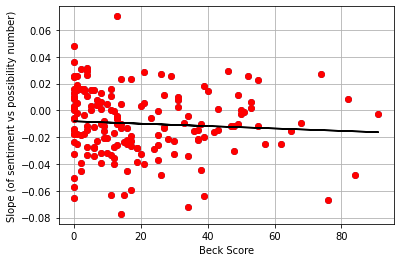

r-value:-0.072359
p-value:0.348392


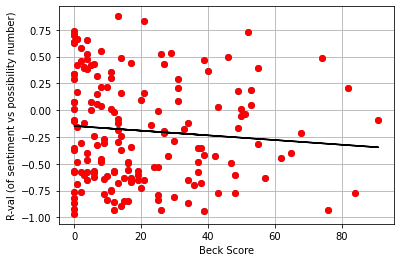

r-value:-0.089213
p-value:0.247306


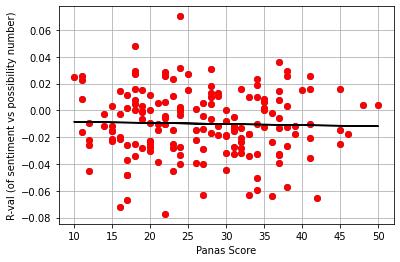

r-value:-0.030383
p-value:0.694091


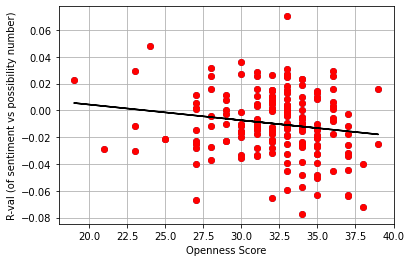

r-value:-0.162595
p-value:0.034136


In [20]:
# Test: Sentiment Gradient vs. Beck 
# I will try and conduct the following test here: 
# 1. Find the average possibility sentiment score for each participant. Find the slope of this plot. 
# 2. Find the beck score for each participant 
# 3. Plot slope vs bdi
# Variation: I will also run the same test but with pearson's r instead of slope...
slopes = {}
pearsons = {}
for id in gscores:
  x = []
  y = []
  for num in gscores.get(id):
    x.append(num)
    y.append(gscores.get(id).get(num))
  slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
  slopes[id] = slope
  pearsons[id] = r_value

x = []
y = []
yp = []
for id in slopes:
  if id in ascores: # this line is here because there is some discrepancy between the ids in the information table and the generations table
    x.append(ascores.get(id).get('beck'))
    y.append(slopes.get(id))
    yp.append(pearsons.get(id))

  
x = np.array(x)
y = np.array(y)
plt.scatter(x, y)
plt.xlabel("Beck Score")
plt.ylabel("Slope (of sentiment vs possibility number)")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#second graph 
x = np.array(x)
y = np.array(yp)
plt.scatter(x, y)
plt.xlabel("Beck Score")
plt.ylabel("R-val (of sentiment vs possibility number)")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#sentiment gradient vs Panas 
x = []
y = []
for id in slopes:
  if id in ascores: # this line is here because there is some discrepancy between the ids in the information table and the generations table
    x.append(ascores.get(id).get('panas_pos'))
    y.append(slopes.get(id))
x = np.array(x)
y = np.array(y)
plt.scatter(x, y)
plt.xlabel("Panas Score")
plt.ylabel("R-val (of sentiment vs possibility number)")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#sentiment gradient vs openness
x = []
y = []
for id in slopes:
  if id in ascores: # this line is here because there is some discrepancy between the ids in the information table and the generations table
    x.append(ascores.get(id).get('openness'))
    y.append(slopes.get(id))
x = np.array(x)
y = np.array(y)
plt.scatter(x, y)
plt.xlabel("Openness Score")
plt.ylabel("R-val (of sentiment vs possibility number)")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

In [21]:
# TEST: Variation v.s. Beck 

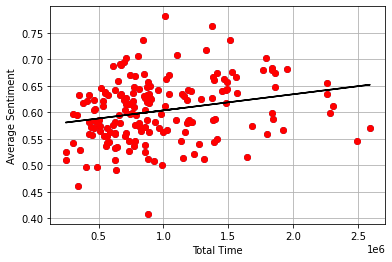

r-value:0.248195
p-value:0.000836


In [22]:
# TEST: Avg Sentiment v.s. Total Time
avgs = []
ttime = []
time_dic = {}
for id, group in generations.groupby('id'):
    time_dic[id] = group['generation_time'].sum()

for id in gscores:
  s = 0
  for score in gscores.get(id):
    s += gscores.get(id).get(score)
  avgs.append(s/6)
  ttime.append(time_dic.get(id))
  
x = np.array(ttime)
y = np.array(avgs)

plt.scatter(x, y)
plt.xlabel("Total Time")
plt.ylabel("Average Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#can further stratify by beck score

/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


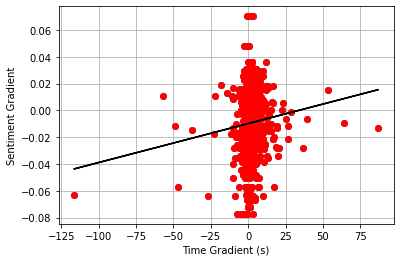

r-value:0.072829
p-value:0.002120


In [23]:
#TEST: Sentiment Gradient vs Time Gradient 
time_gradient = []
time_gradient_dic = {}
sentiment_gradient = []
for id, group in generations.groupby("id"):
  time_gradient_dic[id] = []
  for vign, group2 in group.groupby("vignette_name"):
    numbers = group2['generation_number']
    times = group2['generation_time']
    x = np.array(numbers)
    y = np.array(times)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    time_gradient.append(slope)
    time_gradient_dic.get(id).append(slope)
    sentiment_gradient.append(slopes.get(id))

for id in time_gradient_dic:
  time_gradient_dic[id] = sum(time_gradient_dic.get(id))/len(time_gradient_dic.get(id))
i = 0
while i < len(time_gradient):
  if pd.isna(time_gradient[i]):
    time_gradient.pop(i)
    sentiment_gradient.pop(i)
    i -= 1
  i += 1
x = np.array(time_gradient)
x /= 1000
y = np.array(sentiment_gradient)
plt.scatter(x, y)
plt.xlabel("Time Gradient (s)")
plt.ylabel("Sentiment Gradient")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

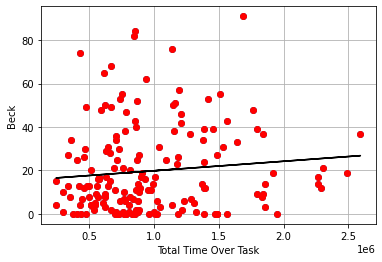

r-value:0.105512
p-value:0.170881


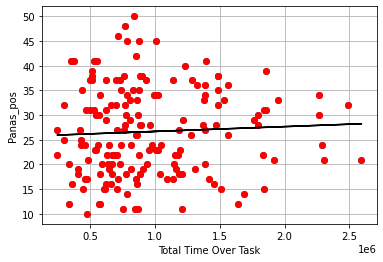

r-value:0.052530
p-value:0.496295


In [24]:
#total generation time vs beck/panas
times = []
beck = []

for id in time_dic:
  if id in ascores:
    times.append(time_dic.get(id))
    beck.append(ascores.get(id).get('beck'))

x = np.array(times)
y = np.array(beck)
plt.scatter(x, y)
plt.xlabel("Total Time Over Task")
plt.ylabel("Beck")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#against Panas

times = []
panas = []

for id in time_dic:
  if id in ascores:
    times.append(time_dic.get(id))
    panas.append(ascores.get(id).get('panas_pos'))

x = np.array(times)
y = np.array(panas)
plt.scatter(x, y)
plt.xlabel("Total Time Over Task")
plt.ylabel("Panas_pos")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

In [25]:
#Average time per possibility vs openness/panas/beck
avg_time = {}
for id, group in generations.groupby('id'):
  avg_time[id] = group['generation_time'].sum()/len(group['generation_time'])


In [26]:
avg_time

{'5563984afdf99b672b5749b6': 13524.17543859649,
 '5591827dfdf99b4fccbdfb21': 28930.01851851852,
 '55c43918fdf99b080551e044': 31544.98245614035,
 '55d5e2c9db6a810006fa078b': 21676.854166666668,
 '55f0c4ba4779250012dd2ff5': 10161.051724137931,
 '566a1d697da0350005b39de3': 26141.964912280702,
 '56797198c3041a0012b64b5e': 17614.775862068964,
 '56f29effed0cf60006911528': 8010.5344827586205,
 '570521cfde5095001018a0c8': 17396.896551724138,
 '573a8aca67421f000f191c52': 14147.228070175439,
 '57509d9b363e77000695620b': 9387.473684210527,
 '5758a211cb13810006479a0d': 14031.620689655172,
 '57b60487e5b60d0001083aea': 8049.254237288135,
 '57f2da5c6c19420001438d19': 14648.85,
 '58064d91f25c440001678a10': 21623.254545454547,
 '581649f0b434f0000184d2a9': 34036.92592592593,
 '5832fa8996ecce0001d65197': 10946.084745762711,
 '585eb4cfc34844000174d807': 20092.51923076923,
 '589ce4d65e63bf00013b3175': 12094.862068965518,
 '58be162d2e4dc0000164b12c': 27088.18181818182,
 '58d3dad59dbe3f0001258f66': 17919.659

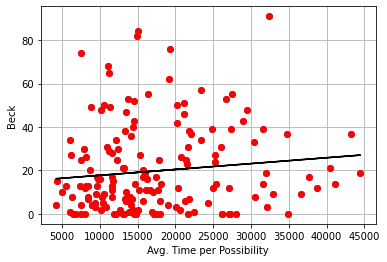

r-value:0.116283
p-value:0.131022


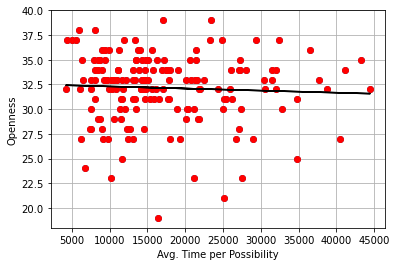

r-value:-0.052995
p-value:0.492490


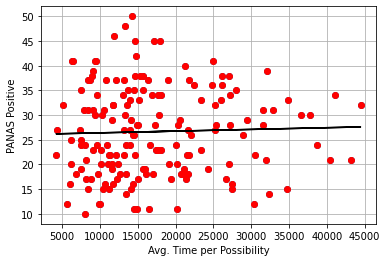

r-value:0.033362
p-value:0.665815


In [27]:
#avg. time per pos vs beck
times = []
beck = []

for id in avg_time:
  if id in ascores:
    times.append(avg_time.get(id))
    beck.append(ascores.get(id).get('beck'))

x = np.array(times)
y = np.array(beck)
plt.scatter(x, y)
plt.xlabel("Avg. Time per Possibility")
plt.ylabel("Beck")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#avg. time per pos vs openness
times = []
openness = []

for id in avg_time:
  if id in ascores:
    times.append(avg_time.get(id))
    openness.append(ascores.get(id).get('openness'))

x = np.array(times)
y = np.array(openness)
plt.scatter(x, y)
plt.xlabel("Avg. Time per Possibility")
plt.ylabel("Openness")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#avg. time per pos vs panas
times = []
panas = []

for id in avg_time:
  if id in ascores:
    times.append(avg_time.get(id))
    panas.append(ascores.get(id).get('panas_pos'))

x = np.array(times)
y = np.array(panas)
plt.scatter(x, y)
plt.xlabel("Avg. Time per Possibility")
plt.ylabel("PANAS Positive")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

In [28]:
#difference between the internal ratings and predicted sentiment 
difference_dic = {}
for id, group in generations.groupby('id'):
  difference_dic[id] = 0
  for row in zip(group['response'].tolist(), group['reflection_score'].tolist()):
    if not pd.isna(row[0]):
      difference_dic[id] = difference_dic.get(id) + abs(predict_sentiment(row[0]) - row[1])


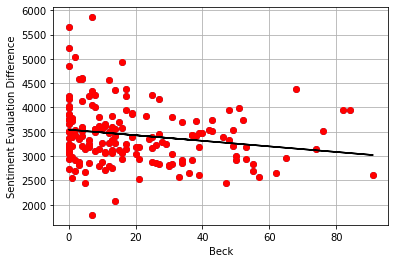

r-value:-0.184706
p-value:0.015896


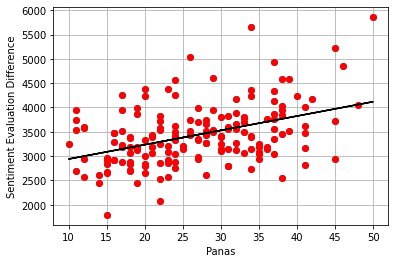

r-value:0.425561
p-value:0.000000


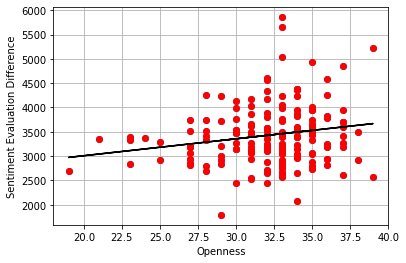

r-value:0.192211
p-value:0.012036


In [29]:
#for beck
difference = []
beck = []
panas = []
openness = []
for id in difference_dic:
  if id in ascores:
    difference.append(difference_dic.get(id))
    beck.append(ascores.get(id).get('beck'))
    panas.append(ascores.get(id).get('panas_pos'))
    openness.append(ascores.get(id).get('openness'))

x = np.array(beck)
y = np.array(difference)
plt.scatter(x, y)
plt.xlabel("Beck")
plt.ylabel("Sentiment Evaluation Difference")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#for panas

x = np.array(panas)
y = np.array(difference)
plt.scatter(x, y)
plt.xlabel("Panas")
plt.ylabel("Sentiment Evaluation Difference")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

# openness 
x = np.array(openness)
y = np.array(difference)
plt.scatter(x, y)
plt.xlabel("Openness")
plt.ylabel("Sentiment Evaluation Difference")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)



/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.7/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


{'5563984afdf99b672b5749b6': -7.341428571428571, '5591827dfdf99b4fccbdfb21': -0.9929324605871706, '55c43918fdf99b080551e044': -4.686312292358805, '55d5e2c9db6a810006fa078b': -4.269082760696988, '55f0c4ba4779250012dd2ff5': -11.677408637873755, '566a1d697da0350005b39de3': -3.2059459459459463, '56797198c3041a0012b64b5e': -5.427176079734219, '56f29effed0cf60006911528': -5.1264864864864865, '570521cfde5095001018a0c8': -1.746756756756757, '573a8aca67421f000f191c52': -3.502625482625482, '57509d9b363e77000695620b': -12.390659340659342, '5758a211cb13810006479a0d': -4.163948100924845, '57b60487e5b60d0001083aea': 3.605714285714286, '57f2da5c6c19420001438d19': -12.731428571428571, '58064d91f25c440001678a10': -5.265824175824176, '581649f0b434f0000184d2a9': -6.6589189189189195, '5832fa8996ecce0001d65197': -8.315444015444015, '585eb4cfc34844000174d807': -9.970024692466552, '589ce4d65e63bf00013b3175': -4.57249169435216, '58be162d2e4dc0000164b12c': -2.6088704318936875, '58d3dad59dbe3f0001258f66': -5.28

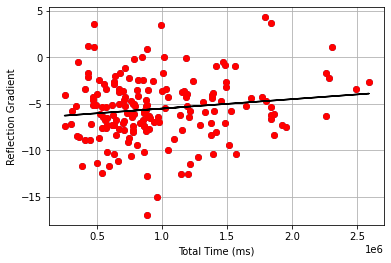

r-value:0.141022
p-value:0.061172


In [30]:
#self reflection gradient vs total time 
reflection_gradient = {}
for id, group in generations.groupby("id"):
  reflection_gradient[id] = []
  for vign, group2 in group.groupby("vignette_name"):
    numbers = group2['generation_number']
    score = group2['reflection_score']
    x = np.array(numbers)
    y = np.array(score)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    reflection_gradient.get(id).append(slope)

for id in reflection_gradient:
  reflection_gradient[id] = sum(reflection_gradient.get(id))/len(reflection_gradient.get(id))
print(reflection_gradient)
reflections = []
times = []
for id in reflection_gradient:
  if not pd.isna(reflection_gradient.get(id)) and not pd.isna(time_dic.get(id)):
    reflections.append(reflection_gradient.get(id))
    times.append(time_dic.get(id))

x = np.array(times)
y = np.array(reflections)
plt.scatter(x, y)
plt.xlabel("Total Time (ms)")
plt.ylabel("Reflection Gradient")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

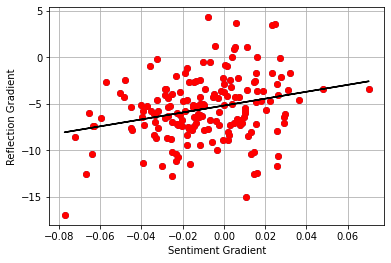

r-value:0.265421
p-value:0.000356


In [31]:
#reflection gradient vs sentiment gradient 
sentiment = []
reflection = []

for id in reflection_gradient:
  if not pd.isna(slopes.get(id)) and not pd.isna(reflection_gradient.get(id)):
    sentiment.append(slopes.get(id))
    reflection.append(reflection_gradient.get(id))

x = np.array(sentiment)
y = np.array(reflection)
plt.scatter(x, y)
plt.xlabel("Sentiment Gradient")
plt.ylabel("Reflection Gradient")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

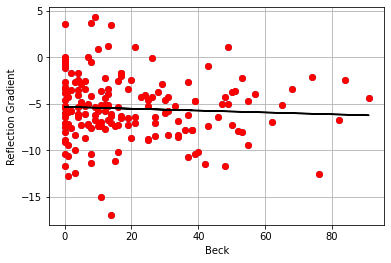

r-value:-0.058243
p-value:0.450588


In [32]:
#reflection gradient vs beck 
reflection = []
beck = []
for id in reflection_gradient:
  if id in ascores:
    reflection.append(reflection_gradient.get(id))
    beck.append(ascores.get(id).get('beck'))

x = np.array(beck)
y = np.array(reflection)
plt.scatter(x, y)
plt.xlabel("Beck")
plt.ylabel("Reflection Gradient")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

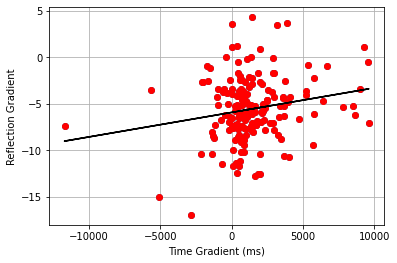

r-value:0.195940
p-value:0.008956


In [33]:
#reflection gradient vs time gradient 
reflection = []
time = []

for id in reflection_gradient:
  if not pd.isna(time_gradient_dic.get(id)) and not pd.isna(reflection_gradient.get(id)):
    reflection.append(reflection_gradient.get(id))
    time.append(time_gradient_dic.get(id))

x = np.array(time)
y = np.array(reflection)
plt.scatter(x, y)
plt.xlabel("Time Gradient (ms)")
plt.ylabel("Reflection Gradient")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

In [34]:
generations

,vignette_name,generation_number,generation_time,response,reflection_score,id
0,ring,0,12767,make fake rings,55,5ae208fe38df950001454cc3
1,ring,1,8718,call the taxi driver,75,5ae208fe38df950001454cc3
2,ring,2,4017,cry,2,5ae208fe38df950001454cc3
3,ring,3,12310,interrupt the bride and groom,61,5ae208fe38df950001454cc3
4,ring,4,8686,run away,1,5ae208fe38df950001454cc3
...,...,...,...,...,...,...
10028,gas,0,3928,tell her no,32,5dfa56fddc265f7ac3bee209
10029,gas,2,7148,take her the whole way,100,5dfa56fddc265f7ac3bee209
10030,gas,3,21327,"take her to my city, then wait while she gets ...",85,5dfa56fddc265f7ac3bee209
10031,gas,4,10469,tell her to call a cab/uber,22,5dfa56fddc265f7ac3bee209


In [43]:
#average goodness rating per possibility 
scores = [[] for i in range(6)]
nums = [i for i in range(6)]
for pnum, group1 in generations.groupby("generation_number"):
  for score in group1['reflection_score']:
    scores[pnum].append(score)

for i in range(len(scores)):
  scores[i] = sum(scores[i])/len(scores[i])

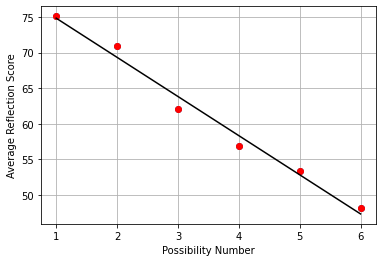

r-value:-0.991983
p-value:0.000096


In [49]:
x = np.array(nums) + 1
y = np.array(scores)
plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Average Reflection Score")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

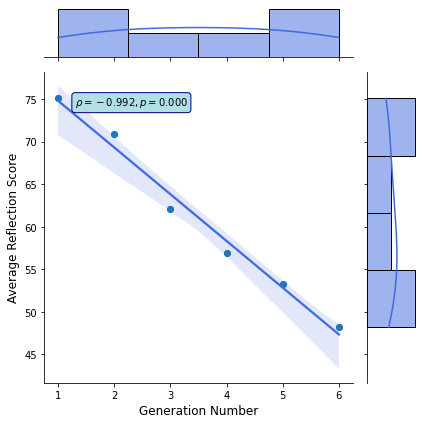

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

# a = np.random.rand(10)
# b = a * 2 + a ** 5

# print("The Rho is {}".format(np.corrcoef(a, b)[0][1]))

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Reflection Score', size=12)
plt.tight_layout()
plt.show()

In [38]:
i = 0 
for id, group in generations.groupby("id"):
  i+=1
  print(i)
#178 for v2 
#

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
